### World-GAN sample visualization (tensor workflow)

This notebook loads **one trained run** from `output/runs/`, then visualizes:
- the discretized **training real** (`random_samples/real_bdata.pt`)
- several discretized **generated samples** (`random_samples/torch_blockdata/*_sc3.pt`)

It uses:
- `MinecraftVisualizerPyVista` for rendering
- `BlockBiomeConverter` to map **model indices → original block IDs** (so the renderer colors the correct blocks)

**Before you run:** set `MAPPINGS_PATH` to your saved mapping file (the one that contains `block_mappings.index_to_block`). If you don’t set it, the notebook will fall back to identity mapping and the render will likely look wrong (especially “air”).



In [9]:
import os
import glob
from pathlib import Path

import torch
import numpy as np
from matplotlib import pyplot as plt

from visualization_utils import MinecraftVisualizerPyVista, BlockBiomeConverter

# --- Select which trained run to visualize ---
# If None, we choose the most recently modified folder under output/runs/
RUN_ID = None  # e.g. "cbskzc1r"

runs_dir = Path("output") / "runs"
assert runs_dir.exists(), f"Missing {runs_dir.resolve()}"

run_dirs = [p for p in runs_dir.iterdir() if p.is_dir()]
assert len(run_dirs) > 0, f"No runs found under {runs_dir.resolve()}"

if RUN_ID is None:
    run_dir = max(run_dirs, key=lambda p: p.stat().st_mtime)
else:
    run_dir = runs_dir / RUN_ID

assert run_dir.exists(), f"Run dir not found: {run_dir.resolve()}"
print("Using run:", run_dir)

samples_dir = run_dir / "random_samples"
assert samples_dir.exists(), f"Missing samples dir: {samples_dir.resolve()}"

real_bdata_path = samples_dir / "real_bdata.pt"
assert real_bdata_path.exists(), f"Missing: {real_bdata_path.resolve()}"

blockdata_dir = samples_dir / "torch_blockdata"
assert blockdata_dir.exists(), f"Missing: {blockdata_dir.resolve()}"

# Pick a few sample files to visualize
sample_paths = sorted(blockdata_dir.glob("*_sc*.pt"))
assert len(sample_paths) > 0, f"No samples found in {blockdata_dir.resolve()}"
print(f"Found {len(sample_paths)} generated samples")

SAMPLE_IDXS = [0, 1, 2, 3]  # change as you like
sample_paths = [sample_paths[i] for i in SAMPLE_IDXS if i < len(sample_paths)]
print("Selected:", [p.name for p in sample_paths])



Using run: output\runs\5x12b8nw
Found 100 generated samples
Selected: ['0_sc2.pt', '10_sc2.pt', '11_sc2.pt', '12_sc2.pt']


In [10]:
# --- Load your index->blockID mapping ---
# This MUST map the model's channel indices (0..C-1) back to original block IDs (e.g. 5=air).
# Provide a mappings file created by your pipeline that contains:
#   {'block_mappings': {'index_to_block': {idx:int(block_id), ...}, ...}, 'biome_mappings': {...}}
#
# If you don't have a mappings.pt yet, set this to None and renders will use identity mapping.
import json
MAPPINGS_PATH = 'datasets/one_sample_per_biome_pt/32_biome_parts_dir_balanced_cc_oh_mappings.pt'  # e.g. "assets/my_mappings.pt"
mappings = torch.load(MAPPINGS_PATH, map_location="cpu", weights_only=False)
converter = BlockBiomeConverter(mappings["block_mappings"], mappings["biome_mappings"]) if mappings is not None else None
TEXTURES_DIR = 'block_textures/'



def indices_to_block_ids_fast(indices: torch.Tensor, index_to_block: dict | None) -> torch.Tensor:
    """Vectorized index->blockID mapping using a LUT. indices is (X,Y,Z) long."""
    indices = indices.to(torch.long)
    if index_to_block is None:
        return indices
    max_idx = int(max(index_to_block.keys()))
    lut = torch.zeros((max_idx + 1,), dtype=torch.long)
    for i, bid in index_to_block.items():
        lut[int(i)] = int(bid)
    return lut[indices]


def render_voxels(voxels_block_ids: torch.Tensor, title: str, *, image_px: int = 512):
    """Render a (X,Y,Z) block-id volume to an inline image."""
    vis = MinecraftVisualizerPyVista(textures_dir=TEXTURES_DIR, build_textures=True)
    plotter = vis.visualize_chunk_textured(voxels_block_ids, interactive=False, show_axis=False)


    img = plotter.screenshot(window_size=(image_px, image_px), transparent_background=False, return_img=True)
    plotter.close()

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(title)
    plt.show()



real_idx (32, 32, 32) torch.int64 min/max 2 99
real_block_ids (32, 32, 32) torch.int64 min/max 5 240
Please install panel with: pip install panel


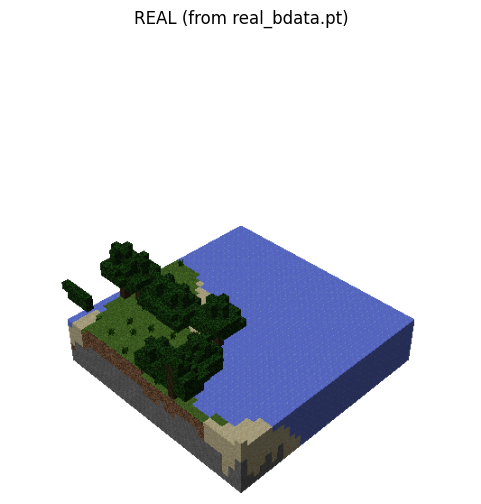

Please install panel with: pip install panel


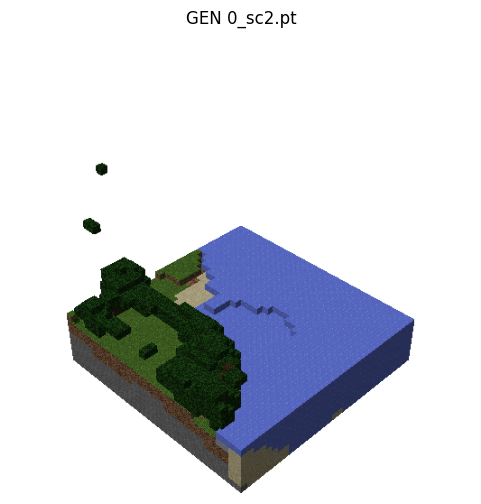

Please install panel with: pip install panel


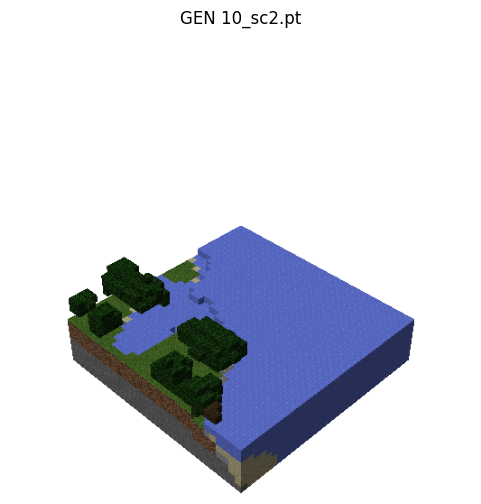

Please install panel with: pip install panel


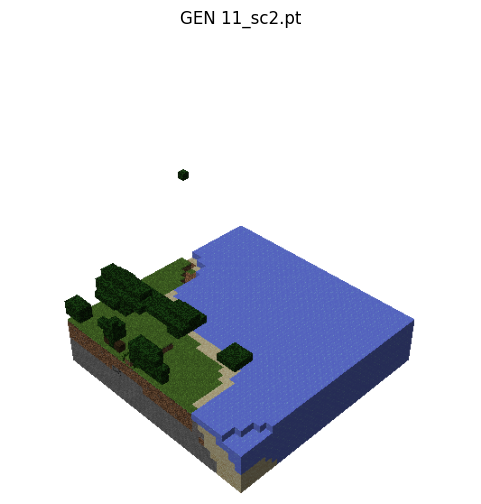

Please install panel with: pip install panel


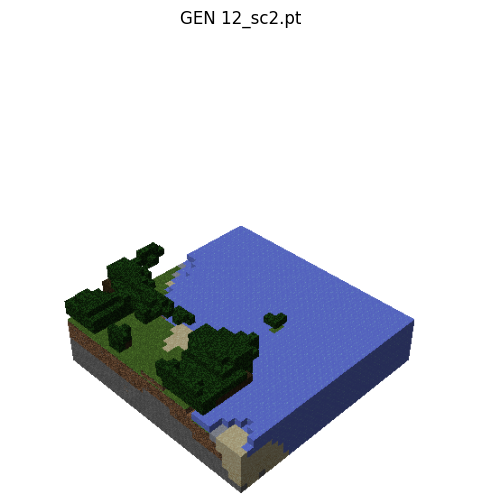

In [11]:
# --- Visualize the training "real" and a few generated samples ---

# Load discretized training sample (model indices)
real_idx = torch.load(real_bdata_path, map_location="cpu")
print("real_idx", tuple(real_idx.shape), real_idx.dtype, "min/max", int(real_idx.min()), int(real_idx.max()))

real_block_ids = indices_to_block_ids_fast(real_idx, getattr(converter, "index_to_block", None))
print("real_block_ids", tuple(real_block_ids.shape), real_block_ids.dtype, "min/max", int(real_block_ids.min()), int(real_block_ids.max()))

render_voxels(real_block_ids, title=f"REAL (from {real_bdata_path.name})")

for p in sample_paths:
    samp_idx = torch.load(p, map_location="cpu")
    samp_block_ids = indices_to_block_ids_fast(samp_idx, getattr(converter, "index_to_block", None))
    render_voxels(samp_block_ids, title=f"GEN {p.name}")


# (Optional) If you want to visualize the raw soft generator output instead of argmaxed indices:
# soft_path = samples_dir / "torch" / sample_paths[0].name  # same filename under torch/
# x = torch.load(soft_path, map_location="cpu")  # (1,C,X,Y,Z)
# idx = x.argmax(dim=1).squeeze(0)
# render_voxels(indices_to_block_ids_fast(idx, getattr(converter, "index_to_block", None)), title=f"GEN (soft->argmax) {soft_path.name}")



2026-01-08 19:56:40.796 | INFO     | generate_samples:generate_samples:88 - Generating samples at scale 0


Sampling on: cuda


100%|██████████| 1/1 [00:00<00:00, 998.41it/s]
2026-01-08 19:56:40.800 | INFO     | generate_samples:generate_samples:88 - Generating samples at scale 1
100%|██████████| 1/1 [00:00<00:00, 333.23it/s]
2026-01-08 19:56:40.818 | INFO     | generate_samples:generate_samples:88 - Generating samples at scale 2
100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


Decoded idx_xyz: (64, 32, 64) target: (64, 32, 64)
Please install panel with: pip install panel


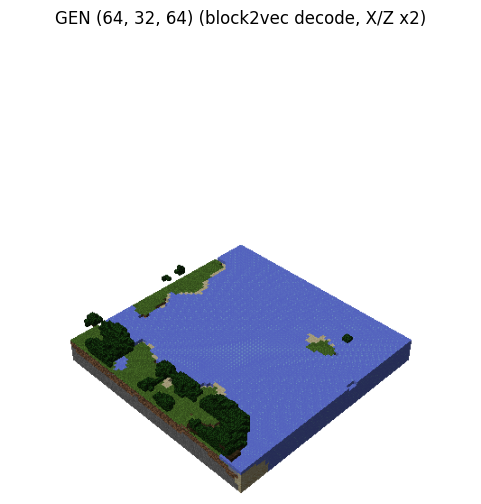

In [24]:
# --- Generate 64x32x64 by calling generate_samples() (double X and Z) ---
# NOTE: This run uses block2vec representations (32-dim), so you MUST decode via nearest-neighbor
# in repr space (repr_type="block2vec"). Argmax on the 32 channels will produce nonsense.

import pickle
import torch
from types import SimpleNamespace

from generate_samples import generate_samples

TARGET_XYZ = (64, 32, 64)  # (X,Y,Z) — matches training tensor layout 1CXYZ

# Empirically (and consistent with 1CXYZ):
# - scale_h scales the 1st spatial dim (X)
# - scale_d scales the 2nd spatial dim (Y)
# - scale_v scales the 3rd spatial dim (Z)
# So to expand X and Z but keep Y fixed:
scale_h = 2.0  # X: 32 -> 64
scale_d = 1.0  # Y: keep 32
scale_v = 2.0  # Z: 32 -> 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Sampling on:", device)

# Load pyramid artifacts
generators = torch.load(run_dir / "generators.pth", map_location=device, weights_only=False)
noise_maps = torch.load(run_dir / "noise_maps.pth", map_location=device, weights_only=False)
noise_amplitudes = torch.load(run_dir / "noise_amplitudes.pth", map_location=device, weights_only=False)
reals = torch.load(run_dir / "reals.pth", map_location=device, weights_only=False)
num_layer = int(torch.load(run_dir / "num_layer.pth", map_location="cpu", weights_only=False))

# Token order for this run (this is what converter.index_to_block expects)
token_list = torch.load(run_dir / "token_list.pth", map_location="cpu", weights_only=False)

# Load block2vec representations and FORCE their order to match token_list
rep_path = "output/block2vec_tensor/beaches/representations.pkl"
with open(rep_path, "rb") as f:
    rep = pickle.load(f)
block2repr = {tok: rep[tok] for tok in token_list}

for g in generators:
    g.to(device).eval()

opt = SimpleNamespace(
    out_=str(run_dir),
    num_layer=num_layer,
    pad_with_noise=False,
    device=device,
    repr_type="block2vec",
    block2repr=block2repr,
    token_list=token_list,
    props=[{} for _ in range(len(token_list))],
    enable_minecraft_io=False,
    input_type="tensor",
    output_dir="",
    output_name="",
)

# generate_samples will save a decoded index volume under torch_blockdata/0_sc{last}.pt
save_dir = "_notebook_tmp_64x32x64"
_ = generate_samples(
    generators,
    noise_maps,
    reals,
    noise_amplitudes,
    opt,
    num_samples=1,
    render_images=False,
    save_tensors=False,
    save_dir=save_dir,
    scale_v=scale_v,
    scale_h=scale_h,
    scale_d=scale_d,
)

# For block2vec, torch_blockdata is already an index volume in (X,Y,Z)
idx_xyz = torch.load(run_dir / save_dir / "torch_blockdata" / "0_sc2.pt", map_location="cpu")
print("Decoded idx_xyz:", tuple(idx_xyz.shape), "target:", TARGET_XYZ)
assert tuple(idx_xyz.shape) == TARGET_XYZ, f"Got {tuple(idx_xyz.shape)} but expected {TARGET_XYZ}"

block_ids_xyz = indices_to_block_ids_fast(idx_xyz, getattr(converter, "index_to_block", None))
render_voxels(block_ids_xyz, title=f"GEN {TARGET_XYZ} (block2vec decode, X/Z x2)")



In [ ]:
# --- Debug: compare token/block distributions (saved training-size sample vs scaled sample) ---

import json
import torch

BLOCK_TYPES = json.load(open('assets/block_types.json', 'r'))

def _topk_counts_1d(values: torch.Tensor, k: int = 10):
    values = values.to(torch.long).reshape(-1)
    uniq, counts = torch.unique(values, return_counts=True)
    counts, order = torch.sort(counts, descending=True)
    uniq = uniq[order]
    total = int(values.numel())
    out = []
    for i in range(min(k, int(uniq.numel()))):
        out.append((int(uniq[i]), int(counts[i]), float(counts[i]) / total))
    return out, total, int(uniq.numel())


def summarize_idx_volume(idx_vol: torch.Tensor, label: str):
    # idx_vol is integer indices (block tokens) with some spatial ordering (we treat it as opaque here)
    top_idx, total, nuniq = _topk_counts_1d(idx_vol, k=12)
    print(f"\n[{label}] idx shape={tuple(idx_vol.shape)} unique={nuniq} total={total}")
    for u, c, p in top_idx:
        print(f"  idx {u:3d}: {p:7.3%}")

    # Map to Minecraft block IDs (if converter mapping is available)
    index_to_block = getattr(converter, 'index_to_block', None)
    if index_to_block is None:
        print("  (no converter/index_to_block; skipping block-id histogram)")
        return

    block_ids = indices_to_block_ids_fast(idx_vol, index_to_block)
    top_bid, _, _ = _topk_counts_1d(block_ids, k=12)
    print(f"[{label}] top block IDs:")
    for bid, c, p in top_bid:
        name = BLOCK_TYPES.get(str(bid), 'UNKNOWN')
        print(f"  id {bid:3d} ({name}): {p:7.3%}")


# Compare one known-good saved sample vs the newly generated scaled one
GOOD_PATH = run_dir / 'random_samples' / 'torch_blockdata' / '0_sc2.pt'
BIG_PATH = run_dir / '_notebook_tmp_64x32x64' / 'torch_blockdata' / '0_sc2.pt'

idx_good = torch.load(GOOD_PATH, map_location='cpu')
idx_big = torch.load(BIG_PATH, map_location='cpu')

summarize_idx_volume(idx_good, 'GOOD (saved at end of training)')
summarize_idx_volume(idx_big, 'NEW 64x32x64 (block2vec decode)')

# Sanity: generate at scale=1 using the SAME block2vec decode, then load the decoded indices
try:
    save_dir_1x = '_notebook_tmp_32x32x32_b2v'
    _ = generate_samples(
        generators,
        noise_maps,
        reals,
        noise_amplitudes,
        opt,
        num_samples=1,
        render_images=False,
        save_tensors=False,
        save_dir=save_dir_1x,
        scale_v=1.0,
        scale_h=1.0,
        scale_d=1.0,
    )
    idx_1x = torch.load(run_dir / save_dir_1x / 'torch_blockdata' / '0_sc2.pt', map_location='cpu')
    summarize_idx_volume(idx_1x, 'NEW 32x32x32 (block2vec decode)')
except Exception as e:
    print('Scale=1 debug sampling failed:', e)



2026-01-08 19:46:29.388 | INFO     | generate_samples:generate_samples:88 - Generating samples at scale 0



[GOOD (saved at end of training)] idx shape=(32, 32, 32) unique=14 total=32768
  idx   2: 77.377%
  idx  99: 11.261%
  idx  86:  4.233%
  idx  76:  1.901%
  idx  27:  1.694%
  idx  53:  1.334%
  idx  42:  0.851%
  idx  77:  0.797%
  idx  44:  0.467%
  idx  18:  0.037%
  idx  56:  0.037%
  idx  49:  0.006%
[GOOD (saved at end of training)] top block IDs:
  id   5 (AIR): 77.377%
  id 240 (WATER): 11.261%
  id 217 (STONE):  4.233%
  id 194 (SAND):  1.901%
  id  60 (DIRT):  1.694%
  id 119 (LEAVES):  1.334%
  id  93 (GRASS):  0.851%
  id 195 (SANDSTONE):  0.797%
  id  95 (GRAVEL):  0.467%
  id  38 (CLAY):  0.037%
  id 131 (LOG):  0.037%
  id 108 (IRON_ORE):  0.006%

[BIG (scale_v=2, scale_d=2)] idx shape=(32, 48, 48) unique=24 total=73728
  idx   8: 82.803%
  idx  13:  5.603%
  idx  10:  3.404%
  idx   0:  3.290%
  idx  27:  1.166%
  idx  23:  1.164%
  idx  29:  0.606%
  idx   9:  0.391%
  idx   1:  0.296%
  idx  30:  0.289%
  idx  21:  0.189%
  idx  11:  0.180%
[BIG (scale_v=2, scale_d=2

100%|██████████| 1/1 [00:00<00:00, 249.60it/s]
2026-01-08 19:46:29.395 | INFO     | generate_samples:generate_samples:88 - Generating samples at scale 1
100%|██████████| 1/1 [00:00<?, ?it/s]
2026-01-08 19:46:29.400 | INFO     | generate_samples:generate_samples:88 - Generating samples at scale 2
100%|██████████| 1/1 [00:04<00:00,  4.58s/it]


[NEW (scale=1 from loaded pyramid)] idx shape=(32, 32, 32) unique=22 total=32768
  idx   8: 72.418%
  idx  13:  7.785%
  idx  10:  5.719%
  idx   0:  5.109%
  idx  27:  2.090%
  idx  23:  2.042%
  idx   9:  0.961%
  idx  29:  0.833%
  idx  11:  0.778%
  idx  26:  0.757%
  idx   1:  0.482%
  idx  30:  0.378%
[NEW (scale=1 from loaded pyramid)] top block IDs:
  id  20 (BONE_BLOCK): 72.418%
  id  29 (CACTUS):  7.785%
  id  22 (BREWING_STAND):  5.719%
  id   0 (ACACIA_DOOR):  5.109%
  id  60 (DIRT):  2.090%
  id  47 (CRAFTING_TABLE):  2.042%
  id  21 (BOOKSHELF):  0.961%
  id  62 (DOUBLE_PLANT):  0.833%
  id  26 (BROWN_MUSHROOM):  0.778%
  id  59 (DIAMOND_ORE):  0.757%
  id   1 (ACACIA_FENCE):  0.482%
  id  63 (DOUBLE_STONE_SLAB):  0.378%
